In [2]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# we will use these later for the CNN
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 7
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [6]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [7]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

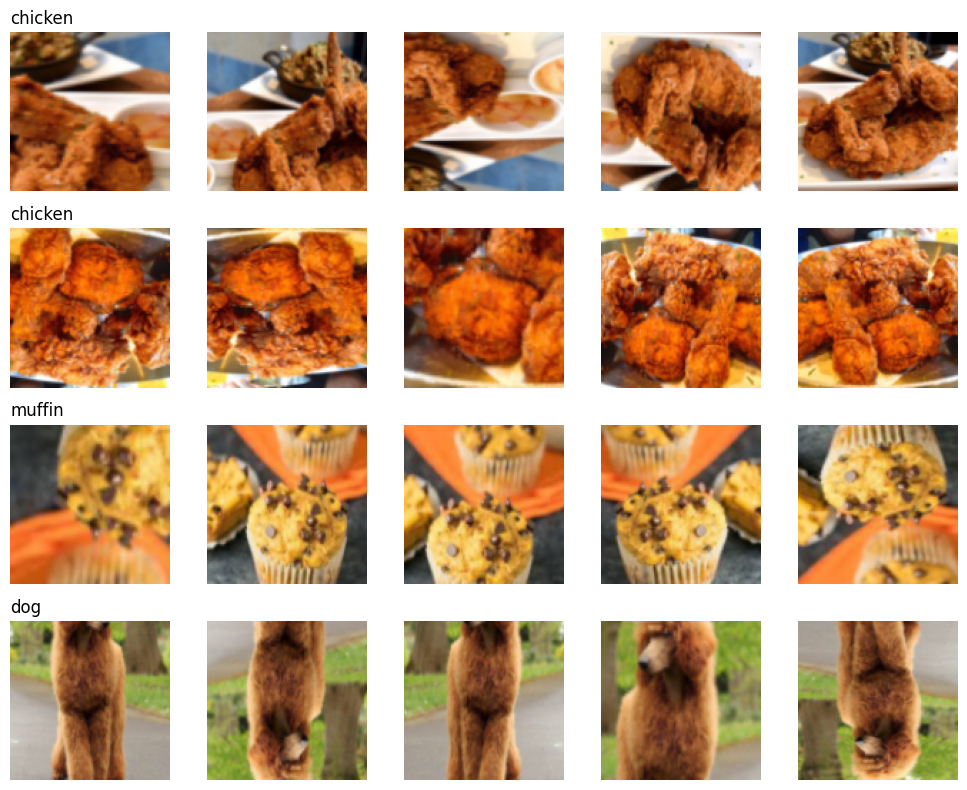

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

    plt.savefig(fname='lab10-task01-visualize-augemented-images.png', format='png')


visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

In [8]:
import pandas as pd
import seaborn as sns

test_labels = []
test_pred_labels = []

class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=num_classes)

        self.test_labels = []
        self.test_pred_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        y_pred = torch.argmax(pred_labels, dim=1)
        self.confusion_matrix.update(y_pred, batch["label"])
        if batch_idx == len(self.trainer.datamodule.test_dataloader()) - 1:
            conf_matrix = self.confusion_matrix.compute().cpu().numpy()

            class_counts = np.sum(conf_matrix, axis=1)
            normalized_conf_matrix = conf_matrix / class_counts[:, np.newaxis]

            print("Confusion Matrix with Class-wise Accuracy:")
            print(normalized_conf_matrix)

            plt.figure(figsize=(num_classes, num_classes))
            class_labels = [str(i) for i in range(num_classes)]
            sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=class_labels, yticklabels=class_labels)

            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title('Confusion Matrix with Class-wise Accuracy')
            plt.show()

    # https://lightning.ai/forums/t/confusion-matrix-in-on-test-epoch-end-argument-error/2423
    # def on_test_epoch_end(self, outputs):
    #     pred_labels = torch.cat([tmp for tmp in self.test_pred_labels])
    #     labels = torch.cat([tmp for tmp in self.test_labels])

    #     confusion_matrix = self.confusion_matrix(pred_labels, labels.int())

    #     confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()

    #     self.log("confusion_matrix", fig_)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

In [9]:
new_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=width),

    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

original_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    # torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    # torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    # torch.nn.BatchNorm2d(num_features=width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    # torch.nn.BatchNorm2d(num_features=width),

    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# model = torchvision.models.mobilenet_v2(num_classes=num_classes, weights="IMAGENET1K_V2")
model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 82.3MB/s]


In [ ]:
import numpy as np
def num_param(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

print(f"Number of trainable of parameters in original model = {num_param(original_model)}\nNumber of trainable of parameters in new model after adding batch norm 2D is = {num_param(new_model)}")


Number of trainable of parameters in original model = 112771
Number of trainable of parameters in new model after adding batch norm 2D is = 113283


In [10]:
lit_model = ImageClassifier(original_model)

In [11]:
wandb_logger = pl.loggers.WandbLogger(project="lab-10", log_model="all", entity='deep-learning-lab-msc', name='lab10-task03-test')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    accelerator="cuda",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: luutunghai (deep-learning-lab-msc). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | Sequential                | 112 K 
1 | accuracy         | MulticlassAccuracy        | 0     
2 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.451     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc_epoch,▁▃▄▄▄▄▅▆▆▆▆▇▇▆▇▇▇▇█▇▇▇▇▇██████
train_acc_step,▃▃▃▄▁▄▅▇▅▄▅▅▅▃▄▇▅▅▂█▅▃▂▇▅▅▂▅▃▄▇▇▄▇▇▇▄▄▇▇
train_loss_epoch,█▆▅▅▅▅▄▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss_step,██▆▆█▅▄▃▄▇▄▄▄▆▇▂▅▅▆▂▃▅▅▄▅▃▇▄▅▄▃▄▃▃▁▂▅▄▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▃▂▄▄▁▅▅▆▆▃▅▇▆▆▇▄▄▇▇▃▇▅▄▇▇▅▇█
val_loss,█▇▇▆▆▆█▄▅▄▃▆▄▃▃▃▃▅▅▂▂▇▂▄▅▂▁▄▂▁
epoch,29
train_acc_epoch,0.72366
train_acc_step,0.75


In [ ]:
# if you stop your training early, run this line manually, to finish the wandb run
wandb.finish()

Your tasks are the following:

1. Add some other type of image augmentation to the training pipeline.
Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.


2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!


3. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.

In [14]:
import numpy as np

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Confusion Matrix with Class-wise Accuracy:
[[0.79475983 0.0349345  0.17030568]
 [0.05882353 0.84705882 0.09411765]
 [0.23308271 0.08646617 0.68045113]]


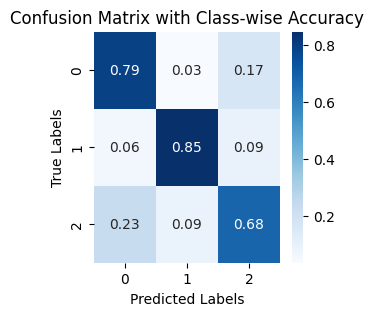

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7720000147819519     │
│         test_loss         │    0.5979989767074585     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5979989767074585, 'test_acc': 0.7720000147819519}]

In [15]:
best_model_path = checkpoint_callback.best_model_path
best_model = ImageClassifier.load_from_checkpoint(best_model_path, model=original_model)
best_model.eval()

trainer = pl.Trainer(
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
)

trainer.test(best_model, datamodule)

In [ ]:
test_pred_labels

[]